In [3]:
import pomegranate
print(pomegranate.GeneralMixtureModel)

<class 'pomegranate.gmm.GeneralMixtureModel'>


NameError: name 'x_range' is not defined

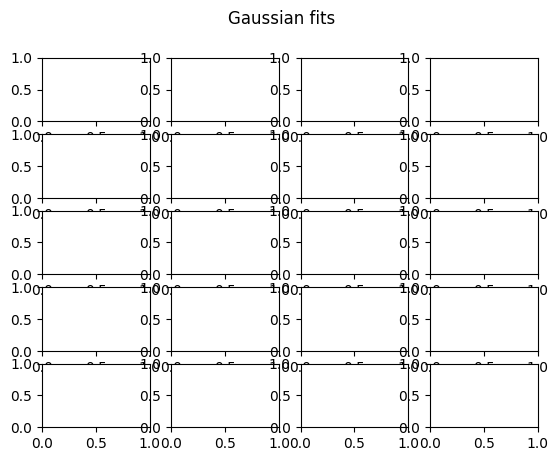

In [4]:
from pomegranate import GeneralMixtureModel, MultivariateGaussianDistribution, IndependentComponentsDistribution, NormalDistribution

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

#from sklearn.mixture import GaussianMixture
from pomegranate import GeneralMixtureModel, MultivariateGaussianDistribution, IndependentComponentsDistribution, NormalDistribution


test_n_components = [2,3,4,5]

fig2, axarr = plt.subplots(5, len(test_n_components))
fig2.suptitle('Gaussian fits')

best_bic = float('inf')
best_gmm = None

##

for i, n_comp in enumerate(test_n_components):
    ax1 = axarr[0,i] # First fig row
    ax1.set_xlim(x_range)
    ax1.set_ylim(y_range)
  
  # Like covariance_type='full'
    #gmm = GeneralMixtureModel.from_samples(MultivariateGaussianDistribution,
                                        # n_comp, grid_data, hist_weights, n_init=1) 

   ##Like covariance_type='diag'
    gmm = GeneralMixtureModel.from_samples([NormalDistribution, NormalDistribution],
                                         n_comp, grid_data, hist_weights, n_init = 5, max_kmeans_iterations = 10) 

  
  # Degrees of freedom per Gaussian component: 2 (cov xx, yy[as diag]) + 2 (mean x, y) + 1 (weight)
  # all -1 due to sum weights == 1.0
    df = (5 * n_comp) - 1
    lp = (gmm.log_probability(grid_data) * hist_weights).sum() #sum, as in log space, normally porbs would multiply. 
    bic = float(df * np.log(len(grid_data)) - 2.0 * lp) # For evaluating best n_comp
  
  # For multivarate
    #x_vals_mean = [comp.parameters[0][0] for comp in gmm.distributions]
    #y_vals_mean = [comp.parameters[0][1] for comp in gmm.distributions]
    #covars = np.array([comp.parameters[1] for comp in gmm.distributions])
    #x_vals_std = np.sqrt(covars[:,0,0]) # x to x variance from covar mat
    #y_vals_std = np.sqrt(covars[:,1,1]) # y to y variance from covar mat
  
  # For independent x,y normals
    comp_params = [comp.parameters[0] for comp in gmm.distributions] # Selects IndependentComponentsDistribution for each Gaussian
    x_params = [cp[0].parameters for cp in comp_params] # NormalDistribution for X : Mean, Var pairs
    y_params = [cp[1].parameters for cp in comp_params] # NormalDistribution for Y : Mean, Var pairs
  
    x_vals_mean, x_vals_var = zip(*x_params) 
    y_vals_mean, y_vals_var = zip(*y_params) 
    
  # Sqrt for Var to Std
    x_vals_std = np.sqrt(x_vals_var)
    y_vals_std = np.sqrt(y_vals_var)
  
    ax1.scatter(x_vals_merge, y_vals_merge, s=3, alpha=0.2, c='#B0B0B0')

    ax1.errorbar(x_vals_mean, y_vals_mean, x_vals_std, y_vals_std, fmt='none',
               color='red',alpha=0.3,  label='StdDevs', capsize=0.5)
  
    ax1.scatter(x_vals_mean, y_vals_mean, s=10, c='black', marker='o', label='Means')
  
  
    ax1.set_title(f'{n_comp} comp BIC={bic:.1f}')
  
    if i == 0:
        ax1.legend()
  
  # Component predition of _original_ points 

    ax2 = axarr[1,i] # Second fig row
    ax2.set_xlim(x_range)
    ax2.set_ylim(y_range)

    labels = gmm.predict(test_data_merge)

    for j in range(n_comp):
        selection = labels == j # Bool array
        ax2.scatter(x_vals_merge[selection], y_vals_merge[selection], s=3, alpha=0.2)
  
  # Density estimation of a grid of points
  
    x_points = np.linspace(-1.2, 1.2, n_grid) # Axis points
    y_points = np.linspace(-1.2, 1.2, n_grid)
    
    x_grid, y_grid = np.meshgrid(x_points, y_points) # n_grid , n_grid of coordinates
    x_grid_flat = x_grid.ravel()  # Flatten to list
    y_grid_flat = y_grid.ravel() 
    stacked_points = np.stack([x_grid_flat, y_grid_flat], axis=1) # to get x,y pairs
  
  
    density = gmm.log_probability(stacked_points) # comes as log probabilties
    density = np.exp(density) # Real probs
    density_2d = density.reshape([n_grid, n_grid]) # Restore points grid (of heights)
    
    ax3 = axarr[2,i] # third fig row
    ax3.set_xlim(x_range)
    ax3.set_ylim(y_range)
    ax3.imshow(density_2d, cmap=density_colormap, origin='lower', extent=x_range + y_range) 
    ax3.scatter(x_vals_mean, y_vals_mean, s=10, c='red', marker='*', label='Means')

  
    ax4 = axarr[3,i]
    ax4.contour(x_grid, y_grid, density_2d, levels=n_contours, alpha=0.5, cmap=contour_colormap)
    ax4.scatter(x_vals_mean, y_vals_mean, s=10, c='red', marker='*', label='Means')



    ax5 = axarr[4,i]
   
  # Equalise scale to input
    density_2d *= input_density.sum()/density_2d.sum()
  
    diff = input_density - density_2d
    maxd = 40 # Set by inspection; same scale for all plots


    rms = np.sqrt(np.mean(diff*diff))

    ax5.set_title(f'Residual RMS = {rms:.3}')
    ax5.set_xlim(x_range)
    ax5.set_ylim(y_range)
    ax5.imshow(diff, cmap='coolwarm', vmin=-maxd, vmax=maxd, origin='lower', extent=x_range + y_range)


plt.show()


In [ ]:
RAN_GEN = np.random.default_rng()


n_contours = 16
density_colormap = LinearSegmentedColormap.from_list(name='density', colors=['#FFFFFF','#0080FF','#000080','#000000'], N=256)
contour_colormap = LinearSegmentedColormap.from_list(name='contour', colors=['#B0B0B0','#0080FF'], N=n_contours)


def make_test_data(means, stds, n_points):
    n_dim = means.shape[1]
  
    test_data = []
    
    for mean, std, p in zip(means, stds, n_points):
        test_data.append(RAN_GEN.normal(mean, std, (p, n_dim)))
  
    return test_data

# Some test Gaussian scatters

x_range = y_range = (-1.2, 1.2)

means = np.array([[0.0, 0.0], [0.5, 0.5], [0.5, -0.8], [-0.4, -0.4]]) # [x,y] pairs
stds  = np.array([[0.1, 0.1], [0.3,  0.2], [ 0.17,  0.12], [ 0.2, 0.25]])
n_points = [300] * 5
  
test_data_sep = make_test_data(means, stds, n_points)
test_data_merge = np.concatenate(test_data_sep)


np.random.shuffle(test_data_merge) # To be really fair

fig1, (ax1, ax2, ax3) = plt.subplots(1, 3) # rows, cols
fig1.suptitle('Random sampled inputs')

for sub_array in test_data_sep:
    x_vals = sub_array[:,0] # Col 0
    y_vals = sub_array[:,1] # Col 1
    ax1.scatter(x_vals, y_vals, s=3, alpha=0.3)

ax1.set_title('Original input components')
ax1.set_xlim(x_range)
ax1.set_ylim(y_range)

x_vals_merge, y_vals_merge = test_data_merge.T
ax2.scatter(x_vals_merge, y_vals_merge, s=3, alpha=0.3, c='#B0B0B0')
ax2.set_xlim(x_range)
ax2.set_ylim(y_range)
ax2.set_title('Merged data')

n_grid = 20
# Fake this for now. this is Tim getting hist from scatter plot. he's doing the faking.
hist_data, x_edges, y_edges = test_data_density = np.histogram2d(x_vals_merge, y_vals_merge, bins=(n_grid,n_grid), range=[x_range, y_range])

#getting coords from edges (average, not actual edges, so don't get one too many). but i don't need to worry as i have real time values
x_grid = 0.5 * (x_edges[1:] +  x_edges[:-1])
y_grid = 0.5 * (y_edges[1:] +  y_edges[:-1])

x_grid, y_grid = np.meshgrid(x_grid,y_grid)

grid_data = np.stack([x_grid.ravel(), y_grid.ravel()], axis=1)
hist_weights = hist_data.T.ravel()

# Only use points with some weight. true or false for non zero data. select both based on hist data. 
nonzero = hist_weights > 0
grid_data = grid_data[nonzero]
hist_weights = hist_weights[nonzero]

input_density = hist_data.T #(could have just T'd once at strat bt nevermind)

ax3.set_title('Merged data as a density')
ax3.set_xlim(x_range)
ax3.set_ylim(y_range)
ax3.imshow(input_density, cmap=density_colormap, origin='lower', extent=x_range + y_range) 
